In [89]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from warnings import warn
from matplotlib.widgets import Slider
import time
from tqdm.notebook import tqdm,trange
%load_ext autoreload
%autoreload 2

from hungarian import preprocess, alternate, hungarian3, augment
from transport import gaussian_transport, gaussian_discreatization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


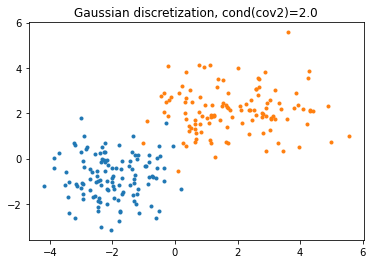

In [3]:
%matplotlib inline
rng = np.random.default_rng(1234)
d = 2
n=120
mean1, mean2 = np.array([-2,-1]), np.array([2,2])
cov1, cov2 = np.array([[1,0],[0,1]]), np.array([[2,0],[0,1]])

transport, W_true = gaussian_transport(mean1, cov1, mean2, cov2)
mu, nu, C = gaussian_discreatization(mean1, cov1, mean2, cov2, n, rng)

plt.plot(mu[:,0],mu[:,1],'.')
plt.title("Gaussian discretization, cond(cov1)="+str(np.linalg.cond(cov1)))
plt.plot(nu[:,0],nu[:,1],'.')
plt.title("Gaussian discretization, cond(cov2)="+str(np.linalg.cond(cov2)))
plt.savefig("graphics/hungarian_mu_nu.pdf")

In [4]:
row,x,phi,U,V, W_hungarian = hungarian3(C)

hungarian3 succed (feasibility and complementary slackness holds)


W_true = 25.17157287525381
W_hungarian = 23.79429798390248
Error = -1.3772748913513269
cond(cov1)= 1.0 cond(cov12)= 2.0


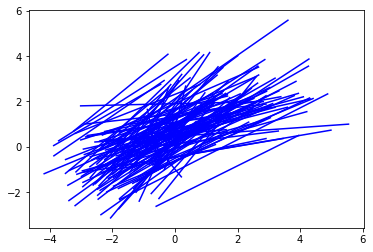

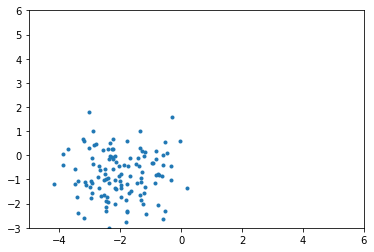

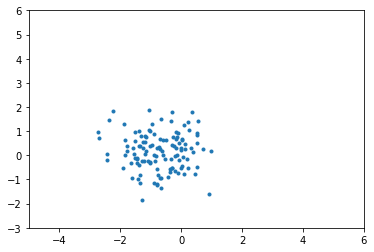

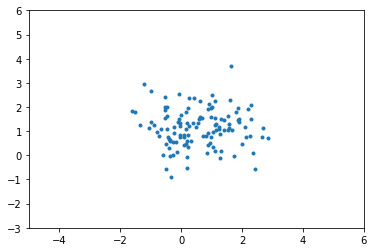

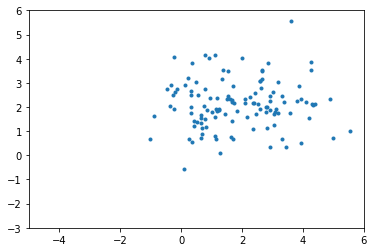

In [5]:
row = row.astype(np.int16)
print("W_true =",W_true)
#transported_mu = np.array([transport(mu[:,i] for i in range(n))]).T
#W_true_discretized = np.sum((mu[:,np.newaxis,:] - transported_mu)**2, axis=2) / n
print("W_hungarian =",W_hungarian)
print("Error =",W_hungarian-W_true)
print("cond(cov1)=",np.linalg.cond(cov1),"cond(cov12)=",np.linalg.cond(cov2))

plt.plot([mu[:,0],nu[row,0]],[mu[:,1],nu[row,1]],'blue')

for i,t in enumerate(np.linspace(0,1,4)):
    plt.figure()
    xx = (1-t)*mu[:,0] + t*nu[row,0]
    yy = (1-t)*mu[:,1] + t*nu[row,1]
    plt.xlim((-5,6))
    plt.ylim((-3,6))
    plt.plot(xx,yy,'.')
    plt.savefig("graphics/hungarian_geodesic"+str(i)+".pdf")

In [6]:
%matplotlib
fig, (ax1,ax2) = plt.subplots(2)
s = Slider(ax = ax2, label = 'time', valmin = 0., valmax = 1., valinit = 0.)
def update(val):
    t=s.val
    xx = (1-t)*mu[:,0] + t*nu[row,0]
    yy = (1-t)*mu[:,1] + t*nu[row,1]
    ax1.cla()
    ax1.set_xlim((-5,5))
    ax1.set_ylim((-3,4))
    ax1.plot(xx,yy,'.')
s.on_changed(update)
update(0)
plt.show()

Using matplotlib backend: <object object at 0x7fdcd9316550>


In [117]:
%matplotlib inline
rng = np.random.default_rng(12345)

transport_true, W_true = gaussian_transport(mean1, cov1, mean2, cov2)

nn = np.linspace(30,120,10).astype(int)
repeat = 20
runtime = np.zeros((len(nn),repeat))
error = np.zeros((len(nn),repeat))

for i,n in tqdm(enumerate(nn),total=len(nn)):
    for j in range(repeat):
        mu, nu, C = gaussian_discreatization(mean1, cov1, mean2, cov2, n, rng)
        tic = time.time()
        row,x,phi,U,V, W_hungarian = hungarian3(C,disp=False)
        runtime[i,j] = time.time() - tic
        error[i,j] = (W_hungarian - W_true) / W_true
runtime = np.vstack((np.mean(runtime,axis=1), np.std(runtime,axis=1)))
error = np.vstack((np.mean(error,axis=1), np.std(error,axis=1)))

  0%|          | 0/10 [00:00<?, ?it/s]

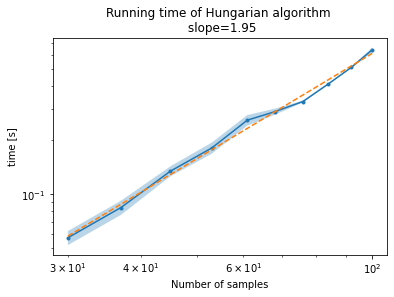

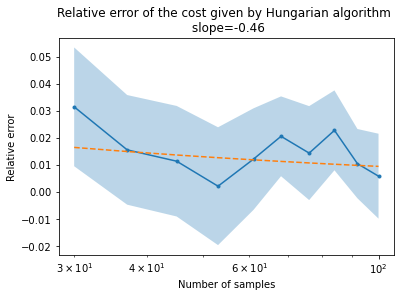

In [120]:
conf_fact = 0.99/np.sqrt(repeat) # 

plt.figure()
plt.plot(nn,runtime[0],'.-')
polynom = np.polyfit(np.log(nn),np.log(runtime[0]),deg=1)
plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
plt.fill_between(nn,runtime[0]-conf_fact*runtime[1],runtime[0]+conf_fact*runtime[1],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title(f"Running time of Hungarian algorithm \n slope={polynom[0]:.2f}")
plt.xlabel("Number of samples")
plt.ylabel("time [s]")
plt.savefig("graphics/hungarian_time.pdf")

plt.figure()
error=np.abs(error)
plt.plot(nn,error[0],'.-')
polynom = np.polyfit(np.log(nn),np.log(error[0]),deg=1)
plt.plot(nn,np.exp(polynom[1])*nn**polynom[0],"--")
plt.fill_between(nn,error[0]-conf_fact*error[1],error[0]+conf_fact*error[1],alpha=0.3)
#plt.yscale('log')
plt.xscale('log')
plt.title(f"Relative error of the cost given by Hungarian algorithm \n slope={polynom[0]:.2f}")
plt.xlabel("Number of samples")
plt.ylabel("Relative error")
plt.savefig("graphics/hungarian_error.pdf")